In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../'))

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import json
from numpy import random
from dataclasses import dataclass

from model.utils import report_results, MetricsResults

from sklearn.ensemble import HistGradientBoostingClassifier

DEFAULT_RANDOM_SEED = 774
random.mtrand._rand.seed(DEFAULT_RANDOM_SEED)
seed_list = random.random_integers(low=0, high=2**32 - 1, size=25)
warnings.filterwarnings("ignore")

In [66]:
@dataclass
class RunConfiguration:
  run_grid_search: bool
  default_parameters: dict

In [67]:
def run_tests(category: str, pvalues: str, select_genes, parameters: dict) -> tuple[int, MetricsResults]:
  data = pd.read_csv(f"../../preprocessed/{category}/genes.csv").drop(columns=["sample_id"])
  pvalues = json.loads(open(f"../../preprocessed/{category}/important_genes_{pvalues}_pvalue.json").readline())

  chosen_genes = select_genes(pvalues)
  df = data[["subtype", "sex", *chosen_genes]]
  results = report_results(df, HistGradientBoostingClassifier, parameters, seed_list)

  return len(chosen_genes), results

In [68]:
X = []
f1 = []
accuracy = []
recall = []

for i in [*range(1, 10), *range(10, 25, 3), *range(25, 50, 5)]:
  gene_count, results = run_tests(
    category="min_tpm_5",
    pvalues="wilcoxon",
    select_genes=lambda pvalues: list(set([y["gene"] for x in [sex_values[:i] for subtype_items in pvalues.values() for sex_values in subtype_items.values()] for y in x])),
    parameters={'learning_rate': 0.1, 'max_features': 0.1, 'l2_regularization': 0, 'max_depth': None}
  )

  X.append(gene_count)
  f1.append(np.median(results.f1.overall))
  accuracy.append(np.median(results.accuracy.overall))
  recall.append(np.median(results.recall.overall))

100%|██████████| 25/25 [02:37<00:00,  6.32s/it]


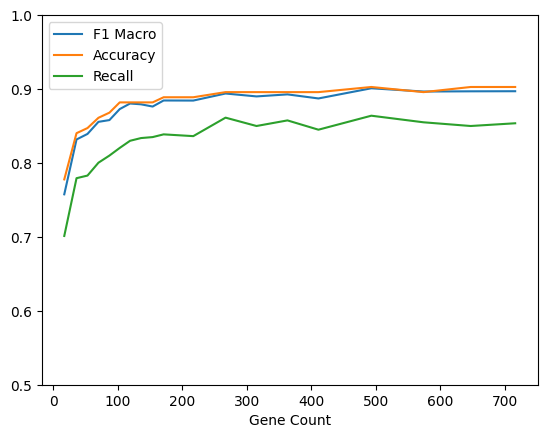

In [71]:
ax = plt.subplot()
p1, = ax.plot(X, f1, label="F1 Macro")
p2, = ax.plot(X, accuracy, label="Accuracy")
p3, = ax.plot(X, recall, label="Recall")

ax.set_xlabel("Gene Count")
ax.set_ylim([0.5, 1])
ax.legend()